In [59]:
import pandas as pd
import numpy as np
import copy as cp
import sklearn.metrics as metrics
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

In [261]:
from heatmap import heatmap, corrplot

## Load and Merge Data

In [3]:
onedrive_path = "C:/Users/cfowle/The Estée Lauder Companies Inc/TeamAnis - General/"

In [11]:
reviews = pd.read_csv(onedrive_path + "Data/Ratings and Reviews/reviews_demand_subcat.csv")
cc      = pd.read_csv(onedrive_path + "Data/Consumer Care/cc_product_month.csv")

C:\Users\cfowle\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
products = pd.read_csv(onedrive_path + "Data/Product/product_codes.csv")

C:\Users\cfowle\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (9,12,23,26,28) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
print(len(reviews))
reviews = reviews.drop("item_description", axis = 1).drop_duplicates()
print(len(reviews))

33702
33667


In [16]:
cc = cc.rename(columns = {"Date Month": "date", "P4": "itemid_4", "Brand Clean": "elc_brand"})
products = products.rename(columns = {"P4": "itemid_4", "brand": "elc_brand", "SubCategory":"sub_category"})
products = products[["elc_brand", "itemid_4", 'Major Category', 'Application', 'Category',
       'sub_category']].drop_duplicates(["elc_brand", "itemid_4"])

In [17]:
cc_product = cc.merge(products, how = "left", on = ["itemid_4", "elc_brand"])

In [26]:
cc_product = cc_product.groupby(["elc_brand", "date", "sub_category"]).sum().reset_index()

In [27]:
cc_reviews_product = reviews.merge(cc_product, how = "left").fillna(0)

## Feature Engineering
### Target Encoding

In [30]:
subcat_map = cc_reviews_product.groupby("sub_category")["demand_F1"].mean().reset_index
brand_map  = cc_reviews_product.groupby("elc_brand")["demand_F1"].mean().reset_index()

cc_reviews_product["month"] = [x[-2:] for x in cc_reviews_product["date"].values]
cc_reviews_product["year"]  = [x[:4] for x in cc_reviews_product["date"].values]

month_map = cc_reviews_product.groupby("month")["demand_F1"].mean().reset_index()
year_map  = cc_reviews_product.groupby("year")["demand_F1"].mean().reset_index()

In [32]:
subcat_map = subcat_map.rename(columns = {"demand_F1":"subcat_avg_demand"})
month_map  = month_map.rename(columns = {"demand_F1":"month_avg_demand"})
year_map   = year_map.rename(columns = {"demand_F1":"year_avg_demand"})
brand_map  = brand_map.rename(columns = {"demand_F1":"brand_avg_demand"})

In [173]:
cc_reviews_product = cc_reviews_product.merge(subcat_map).merge(month_map).merge(year_map).merge(brand_map)
cc_reviews_product = cc_reviews_product.sort_values("date")

### Create dataset without customer data

In [174]:
non_customer_data = cc_reviews_product[["demand_F1", "demand", "demand_P2", "demand_P1", "month", "year",
                                   "subcat_avg_demand", "month_avg_demand", "year_avg_demand", "brand_avg_demand",
                                   "month", "year"]]

### Create Dataset with only Relative Measures

In [175]:
relative_data = cp.deepcopy(non_customer_data)
subcat = cc_reviews_product ##just here so I can copy some old code easily

In [176]:
relative_data["percent_1"] = subcat["rating_1"]/subcat["nb_reviews"]
relative_data["percent_2"] = subcat["rating_2"]/subcat["nb_reviews"]
relative_data["percent_3"] = subcat["rating_3"]/subcat["nb_reviews"]
relative_data["percent_4"] = subcat["rating_4"]/subcat["nb_reviews"]
relative_data["percent_5"] = subcat["rating_5"]/subcat["nb_reviews"]

In [177]:
relative_data["percent_negative"] = subcat['sentiment_negative']/subcat["nb_reviews"]
relative_data["percent_neutral"] = subcat['sentiment_neutral']/subcat["nb_reviews"]
relative_data["percent_positive"] = subcat['sentiment_positive']/subcat["nb_reviews"]

In [178]:
relative_data = relative_data.fillna(0)
relative_data

,demand_F1,demand,demand_P2,demand_P1,month,year,subcat_avg_demand,month_avg_demand,year_avg_demand,brand_avg_demand,month,year,percent_1,percent_2,percent_3,percent_4,percent_5,percent_negative,percent_neutral,percent_positive
12573,0.0,0,0.0,0.0,12,2014,7818.210660,11989.357495,18799.296530,17257.809373,12,2014,0.166667,0.0,0.0,0.250000,0.583333,0.141667,0.100000,0.758333
19237,13179.0,33883,34763.0,33478.0,12,2014,5933.089645,11989.357495,18799.296530,4359.405537,12,2014,0.000000,0.0,0.0,0.125000,0.875000,0.059524,0.133929,0.806548
32036,3460.0,2993,3390.0,2966.0,12,2014,9945.434319,11989.357495,18799.296530,9379.502545,12,2014,0.000000,0.0,0.0,0.000000,1.000000,0.111111,0.111111,0.777778
20598,13736.0,12688,15504.0,12518.0,12,2014,7818.210660,11989.357495,18799.296530,6302.522273,12,2014,0.000000,0.0,0.0,0.333333,0.666667,0.055556,0.227778,0.716667
20599,0.0,0,0.0,0.0,12,2014,5933.089645,11989.357495,18799.296530,6302.522273,12,2014,0.000000,0.0,0.0,0.000000,1.000000,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16976,0.0,0,0.0,0.0,03,2020,4703.272088,10461.578299,6630.341139,7933.452224,03,2020,0.000000,0.0,0.0,0.500000,0.500000,0.000000,0.225000,0.775000
16977,0.0,0,0.0,0.0,03,2020,4703.272088,10461.578299,6630.341139,7933.452224,03,2020,0.000000,0.0,0.0,0.000000,1.000000,0.000000,0.000000,1.000000
16978,0.0,0,414.0,0.0,03,2020,4703.272088,10461.578299,6630.341139,7933.452224,03,2020,0.100000,0.0,0.0,0.100000,0.800000,0.050000,0.076190,0.873810
16980,1623.0,21783,12270.0,14718.0,03,2020,4703.272088,10461.578299,6630.341139,7933.452224,03,2020,0.500000,0.0,0.0,0.000000,0.500000,0.062500,0.312500,0.625000


In [179]:
full_relative_data = cp.deepcopy(relative_data)

In [180]:
subcat["cc_tot"] = subcat['Complaints'] + subcat['Compliments'] + subcat['Questions'] + subcat['Suggestions']

In [181]:
cc_counts = cc.drop(['Product Code', 'itemid_4', 'elc_brand', "date"], axis = 1).columns

In [182]:
for col in cc_counts:
    full_relative_data["percent_" + col] = subcat[col]/subcat["cc_tot"]

In [183]:
full_relative_data = full_relative_data.fillna(0)

In [184]:
full_relative_data

,demand_F1,demand,demand_P2,demand_P1,month,year,subcat_avg_demand,month_avg_demand,year_avg_demand,brand_avg_demand,...,percent_Questions_Order_Returns,percent_Questions_Product_General,percent_Questions_Product_Packaging,percent_Questions_Product_Performance,percent_Questions_Product_Usage Related,percent_Questions_Service_Location,percent_Questions_Service_Miscellaneous,percent_Questions_Website_Offer Codes,percent_Questions_Website_Website functionality,percent_Suggestions_Suggestion_Miscellaneous
12573,0.0,0,0.0,0.0,12,2014,7818.210660,11989.357495,18799.296530,17257.809373,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19237,13179.0,33883,34763.0,33478.0,12,2014,5933.089645,11989.357495,18799.296530,4359.405537,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32036,3460.0,2993,3390.0,2966.0,12,2014,9945.434319,11989.357495,18799.296530,9379.502545,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20598,13736.0,12688,15504.0,12518.0,12,2014,7818.210660,11989.357495,18799.296530,6302.522273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20599,0.0,0,0.0,0.0,12,2014,5933.089645,11989.357495,18799.296530,6302.522273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16976,0.0,0,0.0,0.0,03,2020,4703.272088,10461.578299,6630.341139,7933.452224,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16977,0.0,0,0.0,0.0,03,2020,4703.272088,10461.578299,6630.341139,7933.452224,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16978,0.0,0,414.0,0.0,03,2020,4703.272088,10461.578299,6630.341139,7933.452224,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16980,1623.0,21783,12270.0,14718.0,03,2020,4703.272088,10461.578299,6630.341139,7933.452224,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Build Models
### No Customer Data

In [185]:
X = non_customer_data.drop(["demand_F1"], axis = 1)
y = non_customer_data[["demand_F1"]]

Text(0, 0.5, 'cumulative explained variance')

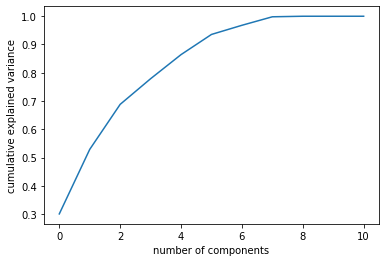

In [186]:
X = StandardScaler().fit_transform(X)
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [187]:
pca = PCA(n_components=6)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents)

In [188]:
X_train, X_test, y_train, y_test = train_test_split(principalDf, y, shuffle = False)

In [189]:
lm = LinearRegression()
lm.fit(X_train, y_train)

pred = lm.predict(X_test)
metrics.r2_score(pred, y_test)

0.32229288503358133

In [190]:
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train.values.reshape(-1,1), X2)
est2 = est.fit()

print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     5605.
Date:                Fri, 19 Jun 2020   Prob (F-statistic):               0.00
Time:                        13:31:50   Log-Likelihood:            -2.9263e+05
No. Observations:               25250   AIC:                         5.853e+05
Df Residuals:                   25243   BIC:                         5.853e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.356e+04    187.823     72.187      0.0

In [191]:
for i,x in enumerate(pca.components_):
    print("Feature " + str(i), ", Explains " + str(pca.explained_variance_[i]) + "%")
    top = x.argsort()[-5:][::-1]
    table = [list(non_customer_data.drop("demand_F1", axis = 1).columns[top]), x[top]]
    df = pd.DataFrame(np.transpose(table))
    print(df)

Feature 0 , Explains 3.304832945778841%
                 0                    1
0  year_avg_demand   0.5050604624414725
1            month  0.26656859905536595
2            month  0.26656859905536584
3           demand  0.16332509513150867
4        demand_P1  0.15866347755712945
Feature 1 , Explains 2.5124304139143736%
                   0                   1
0          demand_P1  0.5053789445315845
1          demand_P2  0.5020396799231963
2             demand  0.4989817574317242
3  subcat_avg_demand  0.3025996943841499
4   brand_avg_demand  0.2208522550409795
Feature 2 , Explains 1.7527418140328614%
        0                    1
0   month   0.6364863278470057
1   month   0.6364863278470055
2    year  0.24973607356343488
3    year   0.2497360735634348
4  demand  0.05094061033073227
Feature 3 , Explains 0.9983645251429656%
                 0                      1
0           demand    0.04730698766633648
1        demand_P1   0.027551092885370276
2  year_avg_demand  0.00022513341096214

### With Smaller Set of Customer Data

In [268]:
X = relative_data.drop(["demand_F1"], axis = 1)
y = relative_data[["demand_F1"]]
X.columns

Index(['demand', 'demand_P2', 'demand_P1', 'month', 'year',
       'subcat_avg_demand', 'month_avg_demand', 'year_avg_demand',
       'brand_avg_demand', 'month', 'year', 'percent_1', 'percent_2',
       'percent_3', 'percent_4', 'percent_5', 'percent_negative',
       'percent_neutral', 'percent_positive'],
      dtype='object')

Text(0, 0.5, 'cumulative explained variance')

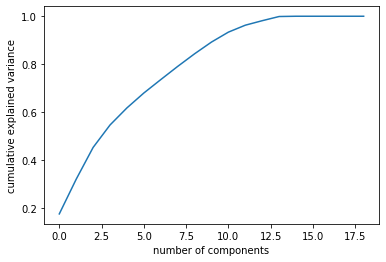

In [269]:
X = StandardScaler().fit_transform(X)
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [270]:
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents)

In [271]:
X_train, X_test, y_train, y_test = train_test_split(principalDf, y, shuffle = False)

In [257]:
lm = LinearRegression()
lm.fit(X_train, y_train)

pred = lm.predict(X_test)
metrics.r2_score(pred, y_test)

0.32074178711251333

In [258]:
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train.values.reshape(-1,1), X2)
est2 = est.fit()

print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     3335.
Date:                Mon, 22 Jun 2020   Prob (F-statistic):               0.00
Time:                        10:38:04   Log-Likelihood:            -2.9269e+05
No. Observations:               25250   AIC:                         5.854e+05
Df Residuals:                   25239   BIC:                         5.855e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.354e+04    188.303     71.901      0.0

In [250]:
X_train, X_test, y_train, y_test = train_test_split(principalDf.iloc[:,:6], y, shuffle = False)

In [251]:
lm = LinearRegression()
lm.fit(X_train, y_train)

pred = lm.predict(X_test)
metrics.r2_score(pred, y_test)

0.2929213615439519

In [252]:
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train.values.reshape(-1,1), X2)
est2 = est.fit()

print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                     5176.
Date:                Mon, 22 Jun 2020   Prob (F-statistic):               0.00
Time:                        09:22:50   Log-Likelihood:            -2.9320e+05
No. Observations:               25250   AIC:                         5.864e+05
Df Residuals:                   25243   BIC:                         5.865e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.362e+04    192.007     70.910      0.0

In [197]:
for i,x in enumerate(pca.components_):
    print("Feature " + str(i), ", Explains "
    top = x.argsort()[-5:][::-1]
    table = [list(relative_data.drop("demand_F1", axis = 1).columns[top]), x[top]]
    df = pd.DataFrame(np.transpose(table))
    print(df)

Feature 0 , Explains 3.3716201121051492%
                  0                    1
0   year_avg_demand   0.4838836710092541
1             month   0.2416443850238452
2             month   0.2416443850238451
3  percent_positive  0.16758496114619267
4            demand  0.15838589022062094
Feature 1 , Explains 2.7445529592635878%
                  0                    1
0  percent_negative   0.4069166491996544
1         percent_1   0.3617825770789422
2   percent_neutral   0.3001716560194428
3         percent_2  0.17688657873102315
4         percent_3   0.1607548631778265
Feature 2 , Explains 2.5108971249049%
                   0                    1
0          demand_P1   0.5070901209689411
1          demand_P2   0.5033932008696687
2             demand   0.5004980206737645
3  subcat_avg_demand  0.30155112668843337
4   brand_avg_demand   0.2219689353200344
Feature 3 , Explains 1.7749017976547288%
                  0                    1
0   year_avg_demand  0.20874224802470387
1         per

### With Full Customer Data

In [215]:
X = full_relative_data.drop(["demand_F1"], axis = 1)
y = full_relative_data[["demand_F1"]]

Text(0, 0.5, 'cumulative explained variance')

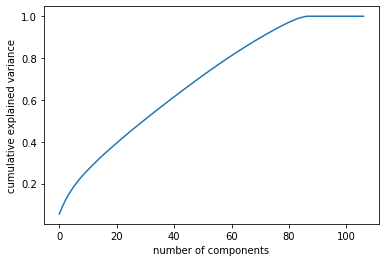

In [216]:
X = StandardScaler().fit_transform(X)
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [217]:
pca = PCA(n_components=30)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents)

In [218]:
X_train, X_test, y_train, y_test = train_test_split(principalDf, y)

In [219]:
lm = LinearRegression()
lm.fit(X_train, y_train)

pred = lm.predict(X_test)
metrics.r2_score(pred, y_test)

0.3675573121093644

In [220]:
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train.values.reshape(-1,1), X2)
est2 = est.fit()

print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     953.5
Date:                Mon, 22 Jun 2020   Prob (F-statistic):               0.00
Time:                        09:03:08   Log-Likelihood:            -2.9270e+05
No. Observations:               25250   AIC:                         5.855e+05
Df Residuals:                   25219   BIC:                         5.857e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.361e+04    164.936     82.540      0.0

In [221]:
for i,x in enumerate(pca.components_):
    print("Feature " + str(i), ", Explains " + str(pca.explained_variance_[i]) + "%")
    top = x.argsort()[-5:][::-1]
    table = [list(full_relative_data.drop("demand_F1", axis = 1).columns[top]), x[top]]
    df = pd.DataFrame(np.transpose(table))
    print(df)

Feature 0 , Explains 5.263594398637577%
                                                   0                    1
0                                 percent_Complaints   0.3822948781106511
1                                  percent_Questions   0.3570115012521052
2  percent_Complaints_Availability_Product Availa...  0.28023449309921006
3                percent_Questions_Availability_GBNF  0.26505336293953313
4               percent_Complaints_Availability_GBNF  0.23127540559605175
Feature 1 , Explains 3.1410817397359145%
                  0                    1
0   year_avg_demand  0.38433652346080543
1             month   0.2533424454537003
2             month  0.25334244545370027
3  percent_positive  0.21220069023870877
4            demand   0.2098984557589623
Feature 2 , Explains 2.7351678568685083%
                  0                    1
0  percent_negative  0.39219820189226695
1         percent_1  0.34536634050336923
2   percent_neutral  0.29013617910606226
3             month   0.

Feature 19 , Explains 1.1210259003164451%
                                                   0                    1
0           percent_Questions_Corporate_Distribution   0.4113130366731603
1  percent_Complaints_Marketing & PR_Marketing Ge...  0.34282223027083414
2                                          percent_3  0.21125241350830531
3                   percent_Questions_Order_Delivery   0.2059374718576703
4  percent_Questions_Formula / Ingredients_Fragrance  0.18153704571087761
Feature 20 , Explains 1.104492854280246%
                                                0                    1
0     percent_Questions_Availability_Where To Buy  0.30177731641079136
1  percent_Questions_Marketing & PR_Brand Program  0.28589293129809146
2                                 percent_neutral  0.25990152232384334
3        percent_Complaints_Product_Usage Related  0.20940203832114393
4               percent_Compliments_Corporate_nan   0.1940442183705148
Feature 21 , Explains 1.0941553655103942%
     

## What if I did PCA on Demand and Customer Info Seperately?

In [125]:
X = non_customer_data.drop(["demand_F1"], axis = 1)
y = non_customer_data[["demand_F1"]]

Text(0, 0.5, 'cumulative explained variance')

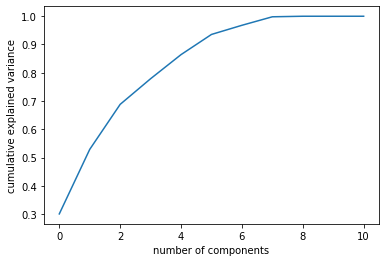

In [126]:
X = StandardScaler().fit_transform(X)
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [127]:
pca = PCA(n_components=6)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents)

### Just R&R

In [167]:
X = relative_data.drop(list(non_customer_data.columns), axis = 1)

Text(0, 0.5, 'cumulative explained variance')

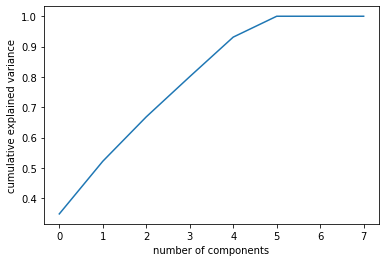

In [168]:
X = StandardScaler().fit_transform(X)
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [169]:
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(X)
principalDf_cust = pd.DataFrame(data = principalComponents)

In [170]:
X = pd.concat([principalDf, principalDf_cust], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [171]:
lm = LinearRegression()
lm.fit(X_train, y_train)

pred = lm.predict(X_test)
metrics.r2_score(pred, y_test)

0.38987150940748505

In [172]:
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train.values.reshape(-1,1), X2)
est2 = est.fit()

print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     2955.
Date:                Fri, 19 Jun 2020   Prob (F-statistic):               0.00
Time:                        13:14:34   Log-Likelihood:            -2.9165e+05
No. Observations:               25250   AIC:                         5.833e+05
Df Residuals:                   25238   BIC:                         5.834e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.354e+04    158.156     85.595      0.0

All of the customer features are completely not significant...

### R&R + CC

In [138]:
X = full_relative_data.drop(list(non_customer_data.columns), axis = 1)

Text(0, 0.5, 'cumulative explained variance')

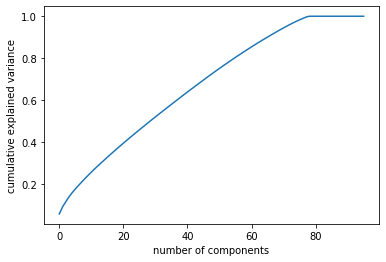

In [139]:
X = StandardScaler().fit_transform(X)
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [140]:
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(X)
principalDf_cust = pd.DataFrame(data = principalComponents)

In [141]:
X = pd.concat([principalDf, principalDf_cust], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [142]:
lm = LinearRegression()
lm.fit(X_train, y_train)

pred = lm.predict(X_test)
metrics.r2_score(pred, y_test)

0.11021456716982747

In [143]:
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train.values.reshape(-1,1), X2)
est2 = est.fit()

print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     1331.
Date:                Fri, 19 Jun 2020   Prob (F-statistic):               0.00
Time:                        13:02:08   Log-Likelihood:            -2.8995e+05
No. Observations:               25250   AIC:                         5.800e+05
Df Residuals:                   25223   BIC:                         5.802e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.349e+04    147.915     91.223      0.0

CC data doesn't help

## What does just a normal regression looks like

In [210]:
X = relative_data.drop(["demand_F1", "percent_5", "percent_positive"], axis = 1)
y = relative_data[["demand_F1"]].values

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False)

In [211]:
lm = LinearRegression()
lm.fit(X_train, y_train)

pred = lm.predict(X_test)
metrics.r2_score(pred, y_test)

0.3295171470105135

In [214]:
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2.astype(float))
est2 = est.fit()

print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     2247.
Date:                Fri, 19 Jun 2020   Prob (F-statistic):               0.00
Time:                        15:16:50   Log-Likelihood:            -2.9261e+05
No. Observations:               25250   AIC:                         5.853e+05
Df Residuals:                   25234   BIC:                         5.854e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -1.23e+06   2.09e+0